## Olympians by Wikipedia Pageviews

### Get a list of competing Olympians

Getting a list of people competing in the Olympics turns out to actually be a pretty difficult thing to do. Olympians are named by any of 240 so-called National Olympic Committees, each of which publishes a list of its athletes&mdash;maybe.

The closest thing to a full list is the apparently maniacally-upkept [sports-reference.com](http://www.sports-reference.com/olympics/summer/2012/) list, which tries to include as close as possible to every Olympian ever. However, they do not have data on the 2016 Olympics available yet.

It is possible to search Wikidata for [participants at the 2016 Summer Games](https://query.wikidata.org/#SELECT%20%3Fitem%20%3FitemLabel%0AWHERE%0A%7B%0A%09%3Fitem%20wdt%3AP1344%20wd%3AQ8613%20.%20%0A%09SERVICE%20wikibase%3Alabel%20%7B%20bd%3AserviceParam%20wikibase%3Alanguage%20%22en%22%20%7D%0A%7D%0A), but the result is hilariously short on results.

Individual Wikipedias contain categories for such things, another approach would be to try to use these. This turns out to be very reasonable: there are ~11,000 Olympians, and [Category:Competitors_at_the_2016_Summer_Olympics](https://en.wikipedia.org/wiki/Category:Competitors_at_the_2016_Summer_Olympics) on the English Wikipedia covers, according to a hand count, at least 10,000 of them. It's quite possible it contains all of them.

Interestingly, for those atheletes that were lacking an article at the beginning of the games, this seems to be due to the work of [one particularly indefatigable user](https://en.wikipedia.org/w/index.php?title=Special:Contributions&offset=20170101000000&limit=100&contribs=user&target=Yellow+Dingo&namespace=&tagfilter=&newOnly=1).

Thus getting a list which is *almost* complete (I doubt that it is totally complete) is a function of reading in this category.

We use the `mwapi` package for this task.

In [1]:
import mwapi
session = mwapi.Session('https://en.wikipedia.org', user_agent='olympian-list-fetch')
print(session.get(action='query', meta='userinfo'))

{'query': {'userinfo': {'name': '108.41.39.170', 'id': 0, 'anon': ''}}, 'batchcomplete': ''}


The category consists of a stack of subcategories, which we read in first.

In [2]:
olympian_wp_categories = session.get(action='query', 
            list='categorymembers', 
            cmtitle='Category:Competitors_at_the_2016_Summer_Olympics',
            cmlimit=500,
            cmtype='subcat')
olympian_wp_categories = [cat['title'] for cat in olympian_wp_categories['query']['categorymembers'] if cat['title'] != 'Category:LGBT sportspeople at the 2016 Summer Olympics']  # avoid double-counting

Then we read in more data from each of the subcategories. The categories might themselves have subcategories, which we have to scope out as well.

Build a list of all cats and subcats.

In [3]:
# Build a list of all cats and subcats.
rio_cat_list = olympian_wp_categories
for cat in rio_cat_list:
    subcats = session.get(action='query',
                          list='categorymembers', 
                          cmtitle=cat,
                          cmlimit=500,
                          cmtype='subcat')
    # Add the subcats to the list, for further exploration.
    rio_cat_list += [cat['title'] for cat in subcats['query']['categorymembers']]

Fetch all of the articles in all of the categories and combine them.

In [4]:
from tqdm import tqdm

athletes_en = []
for cat in tqdm(rio_cat_list):
    subl = []
    cmcontinue = ""
    while True:
        q = session.get(action='query', 
            list='categorymembers', 
            cmtitle=cat,
            cmlimit=500,
            cmtype='page',
            cmcontinue=cmcontinue)
        subl += [d['title'] for d in q['query']['categorymembers']]
        athletes_en += subl
        if 'continue' in q.keys():
            cmcontinue = q['continue']['cmcontinue']
            continue
        else:
            athletes_en += subl
            break

athletes_en = set(athletes_en)

100%|██████████████████████████████████████████| 40/40 [00:05<00:00, 11.51it/s]


In [5]:
len(athletes_en)

9553

In [6]:
len(athletes_en)/11000

0.8684545454545455

About 85% of athletes are represented.

Get the associated Wikidata entities.

I first I tried to use [the following seemingly undescribed capacity](https://en.wikipedia.org/wiki/Special:ApiSandbox#action=query&format=json&prop=iwlinks&list=&titles=Michael+Phelps). As you can see below, this actually only works in a very small minority of cases. The reason why it does so at all, then, is unknown to me.

In [7]:
# wd_items = []
# for athlete in athletes_en:
#     q = session.get(action='query', 
#         format='json', 
#         prop='iwlinks',
#         titles='Michael Phelps')
#     print(q)
#     break

In [8]:
# wd_items = []
# for athlete in tqdm(athletes_en):
#     q = session.get(action='query', 
#         format='json', 
#         prop='iwlinks',
#         titles=athlete)
#     q = q['query']['pages']
#     k = list(q.keys())[0]
#     q = q[k]
#     try:
#         q = q['iwlinks']
#     except:
#         continue
#     wd = [d['*'] for d in q if d['prefix'] == 'd']
#     wd_items += wd

In [9]:
# wd_items

Ok, this clearly (and surprisingly) doesn't work.

After reading documentation on interlanguage link management via Wikidata some more, I discovered that I can hackishly get what I want by examining the redirects I get bounced to when I query `Special:ItemByTitle` on Wikidata ([like so](https://www.wikidata.org/wiki/Special:ItemByTitle?site=enwiki&page=Michael_Phelps)).

Unfortunately it is really slow, but I can't do anything to speed it up easily. `requests.head`, which makes only a `HEAD` request and doesn't download data, would be better, but unfortunately it does not (despite what the Internet seems to show) provide me with a `r.url`, necessitating a `requests.get` fallback (which does have it).

In [14]:
import requests
import time

wd_urls = []
for en_title in tqdm(athletes_en):
    while True:
        try:
            r = requests.get('https://www.wikidata.org/wiki/Special:ItemByTitle?site=enwiki&page={0}'.format(en_title))
            break
        except:
            time.sleep(1)
            continue  # seems to break intermediately otherwise
    wd_urls.append(r.url)

100%|██████████████████████████████████████| 9553/9553 [48:43<00:00,  3.83it/s]


In the following, "S" means that no page was found, while "Q" means that one was.

In [15]:
import pandas as pd

pd.Series([u[:31] for u in wd_urls]).value_counts()

https://www.wikidata.org/wiki/Q    9482
https://www.wikidata.org/wiki/S      71
dtype: int64

We string match to recover endpoints.

In [16]:
wd_endpoints = [url.split('/')[-1] if url[30] != 'S' else None for url in wd_urls]

In [17]:
wd_endpoints[:5]

['Q24809901', 'Q180535', 'Q26422242', 'Q20750665', 'Q138598']

Package this into a DataFrame.

In [18]:
rio = pd.DataFrame(data={'enwiki': list(athletes_en), 'identifier': wd_endpoints})

In [19]:
# rio.to_csv("2016_olympian_pageviews.csv")

These are the English article names. Now we will merge on all of the "other"-wiki names.

In [20]:
from time import sleep
from json import JSONDecodeError

wiki_dict = dict()
n = 0

def wikify(id):
    ret = dict()
#     while True:
#         try:
    if id:
        d = requests.get("https://www.wikidata.org/wiki/Special:EntityData/{0}.json".format(id)).json()
#             break
#         except JSONDecodeError:
#             print("Encountered an error! Trying again...")
#             sleep(1)
#             continue
        sitelinks = d['entities'][id]['sitelinks']
        for wiki in sitelinks.keys():
            title = sitelinks[wiki]['title']
            if wiki in wiki_dict.keys():
                wiki_dict[wiki].append(title)
            else:
                wiki_dict[wiki] = [None]*n
    for wiki in wiki_dict.keys():
        if len(wiki_dict[wiki]) == n:
            wiki_dict[wiki].append(None)

for id in tqdm(rio['identifier']):
    wikify(id)
    n += 1

100%|██████████████████████████████████████| 9553/9553 [26:58<00:00,  6.21it/s]


Now assign that data to our DataFrame.

In [21]:
for lang in wiki_dict.keys():
    rio[lang] = wiki_dict[lang]

This run, a strange `None` appeared in the `enwiki` column.

In [22]:
rio = rio[rio['enwiki'].notnull()]

In combing through what I have so far, I discovered that the categories included a few non-Olympian "junk" pages of the form e.g. `List of divers at the 2016 Summer Olympics`, `Football at the 2016 Summer Olympics`, etc. The string fragment [ `at the` ] is a reliable flag for these articles, which match a community-ordained naming scheme for such articles (`at the`, not `in the` or `play at` or so on...). I now remove these.

How many of these pages are there?

In [23]:
len(rio) - rio['enwiki'].map(lambda n: " at the " not in n).astype(int).sum()

13

Ok, let's remove them.

In [24]:
rio_f = rio[rio['enwiki'].map(lambda n: " at the " not in n)]

In [25]:
rio_f.sample(5)

,enwiki,identifier,eowiki,knwiki,bewiki,fowiki,napwiki,stwiki,glwiki,gdwiki,...,mtwiki,quwiki,dewikiquote,ocwiki,mlwiki,wuuwiki,emlwiki,astwiki,snwiki,srwikinews
5305,Kyrie Irving,Q348618,None,None,None,None,None,None,Kyrie Irving,None,...,None,None,None,None,None,None,None,None,None,None
7865,Panagiotis Samilidis,Q971788,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3384,Josateki Naulu,Q2112287,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
7512,Robenílson de Jesus,Q1894430,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
7780,Alena Sobaleva,Q9147015,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


When you run this notebook from the start, the language data is correctly loaded into the DataFrame in some string format. Since this data includes names from all languages, it uses basically every character glyph you can think of. When you just do `rio.to_csv()`, it saves this data in some encoding format, but not a recoverable one! At least, not one I could get back.

So we need to specify a formal encoding scheme. From poking around it seems that the data is stored natively in `utf-16`, and setting that as the encoding scheme makes everything work as expected on both read and write.

In [26]:
rio_f.to_csv("2016_olympian_pageviews.csv", encoding="utf-16")

Let's take a quick peek at our completeness statistics.

For all wikis (with at least one Olympian entry):

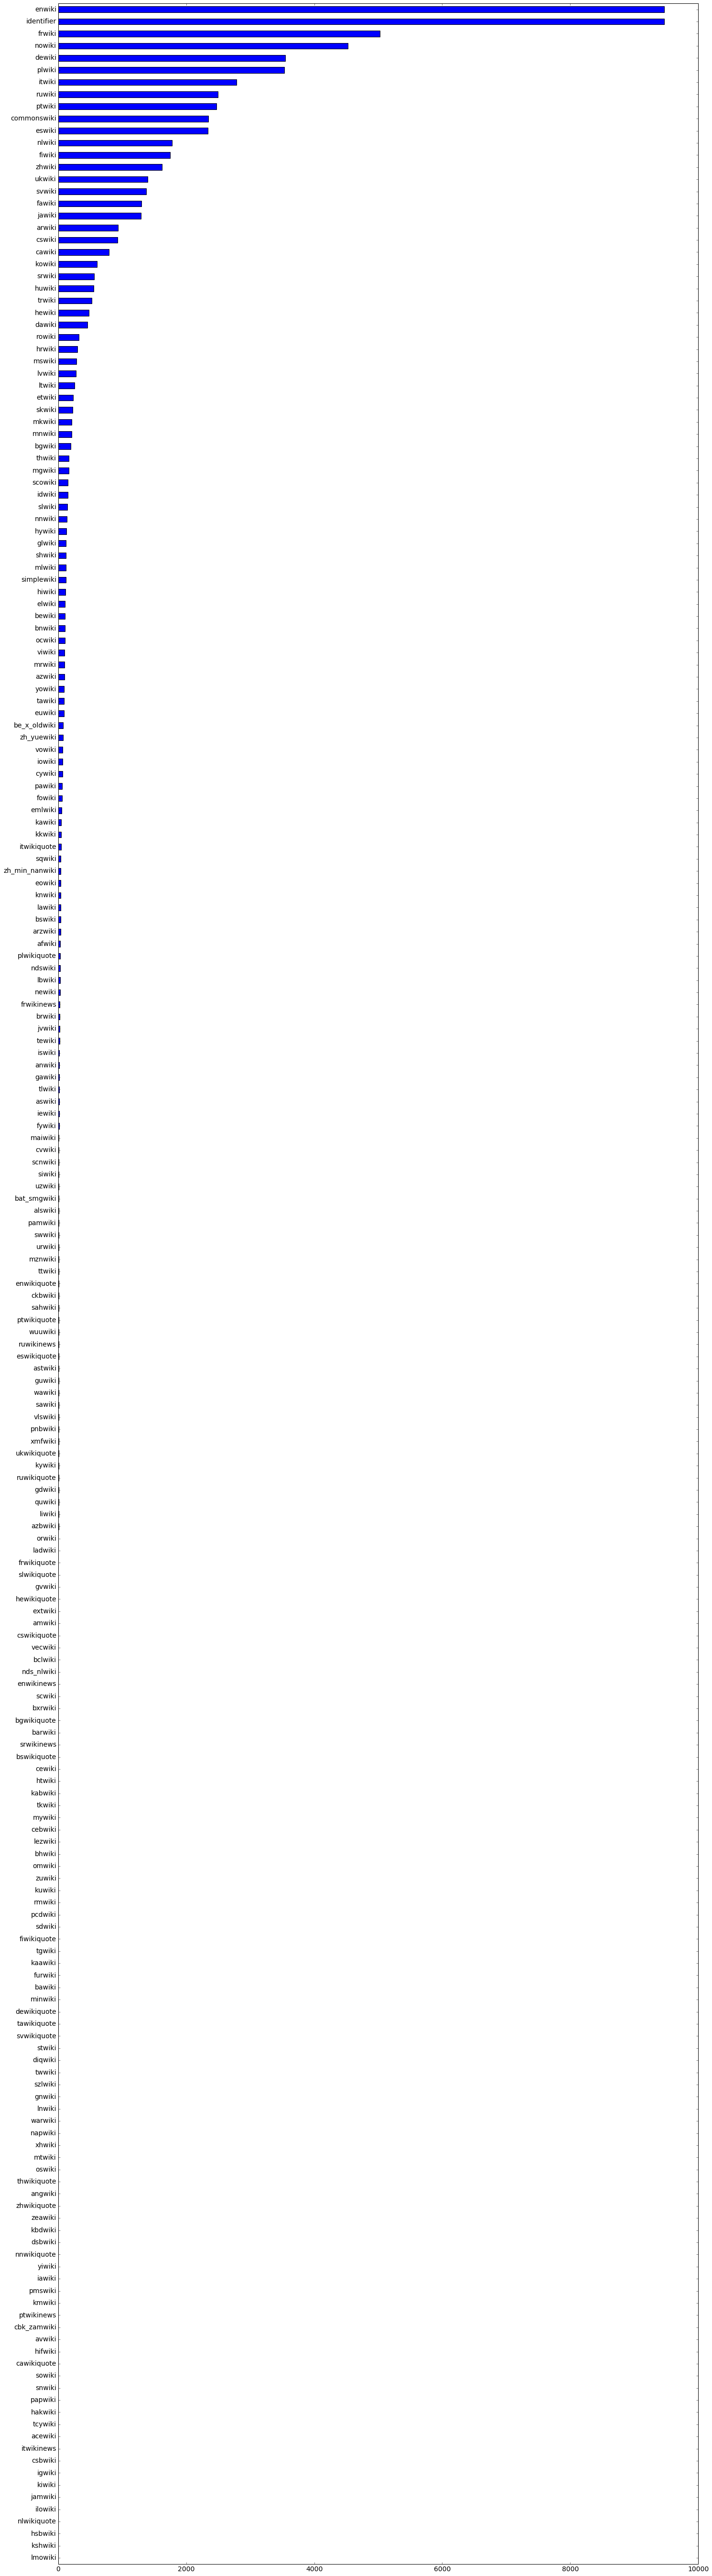

In [27]:
%matplotlib inline
pd.Series(index=rio_f.columns, data=[rio_f[col].notnull().astype(int).sum() for col in rio_f.columns]).sort_values(ascending=True).plot(kind='barh', figsize=(24, 96), fontsize=14)

Just the top 10:

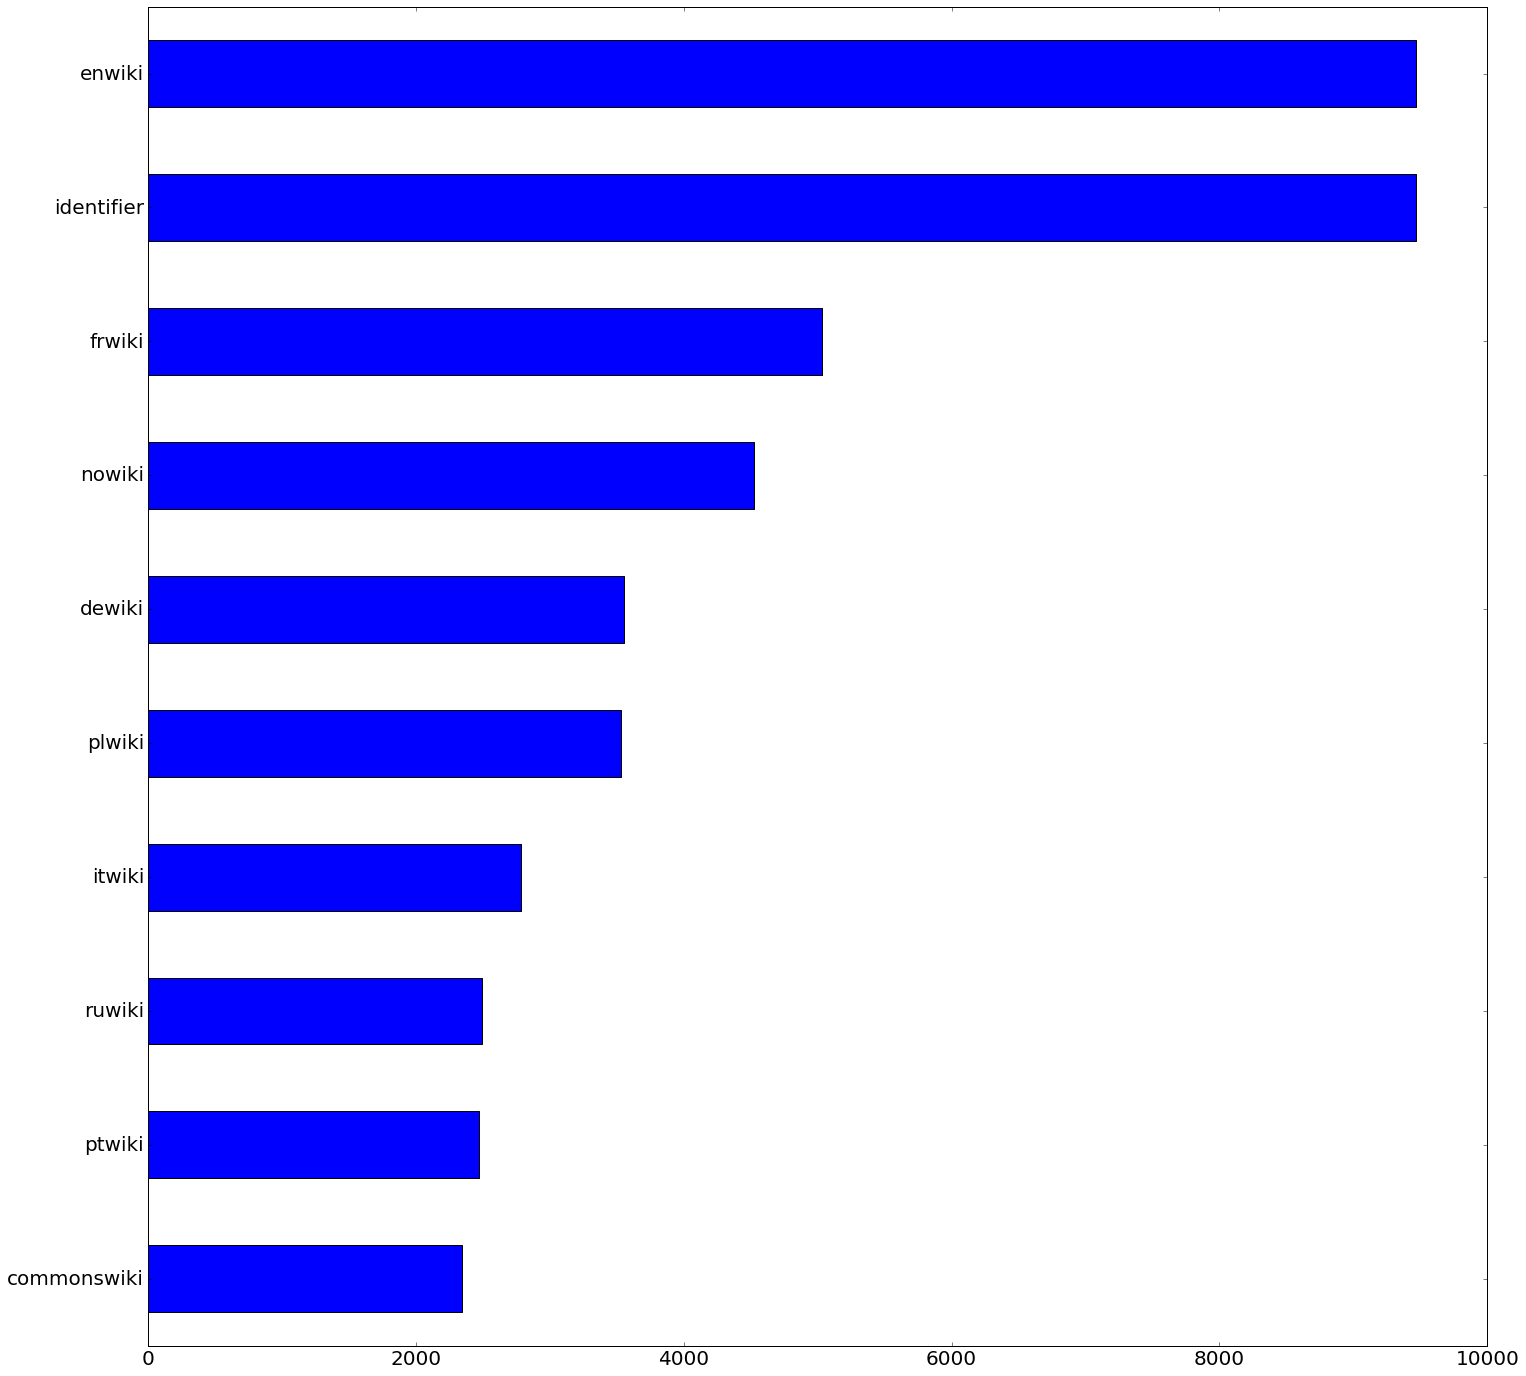

In [28]:
%matplotlib inline
pd.Series(index=rio_f.columns, data=[rio_f[col].notnull().astype(int).sum() for col in rio_f.columns]).sort_values(ascending=False)[:10][::-1].plot(kind='barh', figsize=(24, 24), fontsize=20)

A spot-check shows that this seems to be pretty good in terms of accuracy: the German Wikipedia's [master category](https://de.wikipedia.org/wiki/Kategorie:Teilnehmer_der_Olympischen_Sommerspiele_2016), for example, contains ~3650 entries as of time-of-writing, the same figure we're getting here.

In [29]:
rio_f.head(5)

,enwiki,identifier,eowiki,knwiki,bewiki,fowiki,napwiki,stwiki,glwiki,gdwiki,...,mtwiki,quwiki,dewikiquote,ocwiki,mlwiki,wuuwiki,emlwiki,astwiki,snwiki,srwikinews
1,Juan Martín del Potro,Q180535,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,Gilda Oliveira,Q26422242,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,Cynthia Bolingo,Q20750665,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,Sanna Solberg,Q138598,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
5,Zbigniew Schodowski,Q8067762,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In order to bring in pageview data, we need to be able to map the names given to us here to the actual Wikimedia URI fragments for that wiki, because that is the format that the `PageviewsClient()` expects. So `eswikiquote` needs to become `es.wikiquote`, `enwiki` needs to become `en.wikipedia`, and so on.

Here are the fragments we want:

In [30]:
pd.Series([col[col.find('wiki'):] for col in rio_f.columns if col != "identifier"]).value_counts()

wiki         182
wikiquote     22
wikinews       6
dtype: int64

The following function handles this.

In [31]:
def fragmentize(wiki_id):
    fragment = wiki_id[wiki_id.find('wiki'):]
    if "wikiquote" in fragment:
        return wiki_id[:wiki_id.find("wikiquote")] + ".wikiquote"
    elif "wikinews" in fragment:
        return wiki_id[:wiki_id.find("wikinews")] + ".wikinews"
    elif "wiki" in fragment:
        return wiki_id[:wiki_id.find("wiki")] + ".wikipedia"

In [32]:
fragmentize("itwikiquote")

'it.wikiquote'

In [33]:
fragmentize("enwiki")

'en.wikipedia'

In [34]:
fragmentize("enwikinews")

'en.wikinews'

Next, the following loop fetches that data. First, running this on test data.

In [36]:
rio_test = rio_f.sample(5)

In [ ]:
p.article_views('en.wikipedia', ['Daniel Akpeyi', 'İsmail Keleş', 'Hagen Pohle', 'Florian Floto', 'Matthew Stanley'], start='2016080500', end='2016082100')

In [50]:
from tqdm import tqdm
from mwviews.api import PageviewsClient

p = PageviewsClient()

views_df = pd.DataFrame()

for wiki, col in tqdm(zip([fragmentize(col) for col in rio_test.columns if col != "identifier"],
                          [col for col in rio_test.columns if col != "identifier"])):
    views_series = pd.Series()
    valid_links = [link for link in rio_test[col] if pd.notnull(link)]
    print(valid_links)
    print(wiki)
    data = p.article_views(wiki, valid_links, start='2016080500', end='2016082100')
    view_count_dicts = [data[key] for key in data.keys()]
    names = view_count_dicts[0].keys()
    for name in names:
        views_series[name.replace("_", " ")] = sum([d[name] for d in view_count_dicts if d[name] != None])
    views_df[col + "_views"] = views_series
    break

0it [00:00, ?it/s]

['Misaki Matsutomo', 'Ludovic Chammartin', 'Khadija El-Mardi', 'Angelica Bengtsson', 'Laura Giombini']
en.wikipedia


In [46]:
views_series

Angelica Bengtsson     2521
Laura Giombini         8603
Ludovic Chammartin      503
Misaki Matsutomo      19233
Khadija El-Mardi        895
dtype: int64

In [51]:
views_df

,enwiki_views
Angelica Bengtsson,2521
Laura Giombini,8603
Ludovic Chammartin,503
Misaki Matsutomo,19233
Khadija El-Mardi,895


Great! Now the real thing.

In [62]:
import numpy as np
np.array_split(np.array([1,2,3,4,5,7,6,261,6,1521512,1,12,215,1,]), 2)

[array([1, 2, 3, 4, 5, 7, 6]),
 array([    261,       6, 1521512,       1,      12,     215,       1])]

In [ ]:
from tqdm import tqdm
from mwviews.api import PageviewsClient
import math

p = PageviewsClient()

views_df = pd.DataFrame()

for wiki, col in tqdm(zip([fragmentize(col) for col in rio_f.columns if col != "identifier"],
                          [col for col in rio_f.columns if col != "identifier"])):
    views_series = pd.Series()
    valid_links = [link for link in rio_f[col] if pd.notnull(link)]
    for arr in tqdm(np.array_split(np.array(valid_links), math.floor(len(valid_links) / 10))):
        data = p.article_views(wiki, valid_links, start='2016080500', end='2016082100')
        view_count_dicts = [data[key] for key in data.keys()]
        names = view_count_dicts[0].keys()
        for name in names:
            views_series[name.replace("_", " ")] = sum([d[name] for d in view_count_dicts if d[name] != None])
        views_df[col + "_views"] = views_series

0it [00:00, ?it/s]
  0%|                                                  | 0/946 [00:00<?, ?it/s]

In [ ]:
# # p.article_views('en.wikipedia', ['Pau Gasol', 'Juan Martín López'], start='2016080500', end='2016082100')
# # p.project_views(['ro.wikipedia', 'de.wikipedia', 'commons.wikimedia'])
# # p.top_articles('en.wikipedia', limit=10)

# # The client can do more than the API, for example monthly rollups for article views:
# # p.article_views('en.wikipedia', ['Selfie', 'Cat'], granularity='monthly', start='2016020100', end='2016043000')